In [1]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

import numpy as np

# 강화 학습

강화 학습은 지도 학습, 비지도 학습과 더불어 기계 학습의 범주 중의 하나이다.

강화 학습 분야에 딥러닝을 적용한 예제로 알파고가 있다.

강화 학습에서 에이전트(agent)는 관측(observation)을 하고 주어진 환경(environment)에서 행동(action)을 한다.  

에이전트의 목적은 보상의 장기 기대치를 최대로 만드는 행동을 학습하는 것이다.  

보상에는 양의 보상과 음의 보상이 있다.  

에이전트가 행동을 결정하기 위해 사용하는 알고르즘을 정책(policy)라고 한다.  

예를 들어 관측을 입력으로 받고, 수행할 행동을 출력하는 신경망이 정책이 될 수 있다.

OpenAI gym은 다양한 종류의 시뮬레이션 환경을 제공한다.
이를 사용하여 에이전트를 훈련하는 예제를 진행해 본다.  

In [4]:
import gym

```gym.make```은 환경을 초기화 한다.  

In [5]:
env = gym.make("CartPole-v1")

c:\Users\Owner\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\Owner\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


위에서 선택한 ```CartPole-v1```의 환경은 다음과 같다.
```gym.envs.registry.all()```을 호출하면 생성 가능한 환경의 목록을 얻을 수 있다. 

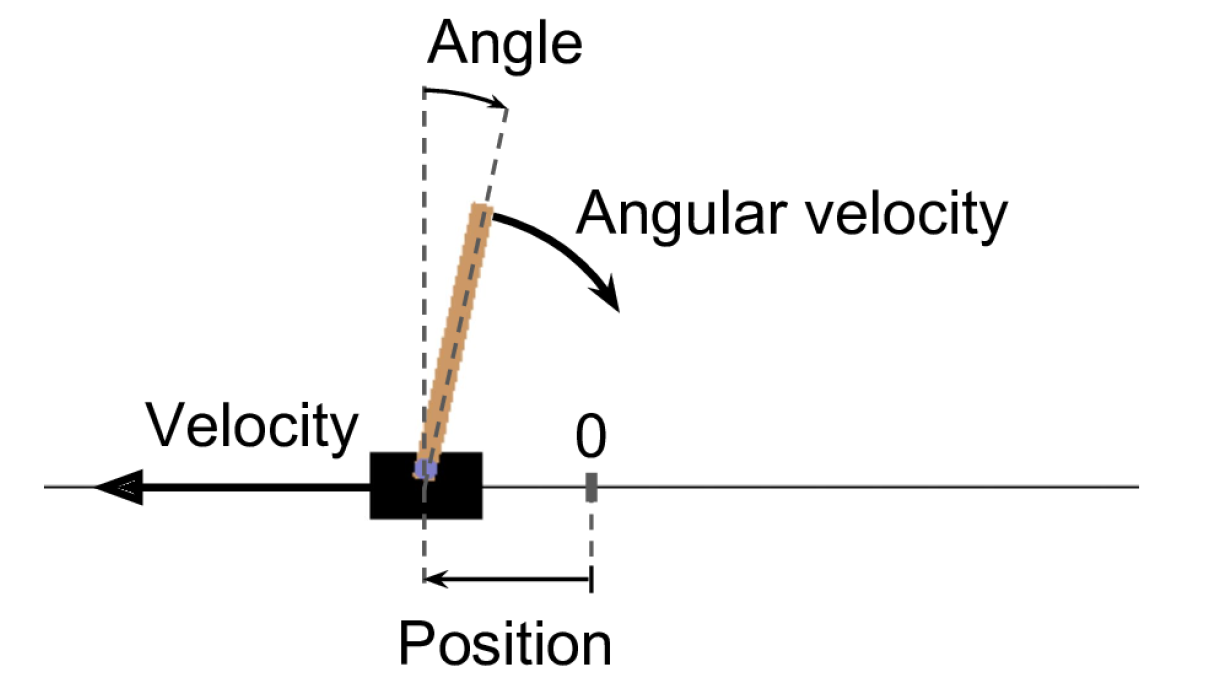

In [6]:
obs = env.reset()

관찰값인 ```obs```는 카트의 수평 위치, 카트의 속도, 막대의 각도, 막대의 각속도를 나타낸다. 

In [7]:
obs

array([-0.006382  ,  0.01343495,  0.02888083, -0.02543116], dtype=float32)

rendering을 통해 막대의 상태를 그림으로 나타낼 수 있다.

In [8]:
render_result = env.render(mode="rgb_array")

c:\Users\Owner\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


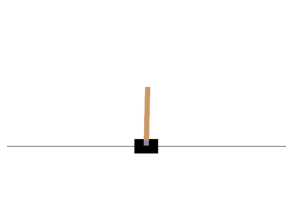

In [9]:
plt.figure(figsize=(5,4))
plt.imshow(render_result)
plt.axis("off")
plt.show()

이 예제에서는 가능한 action은 두 개 뿐이다. 오른쪽(정수 1로 표현) 혹은 왼쪽(정수 0으로 표현)으로 움직이는 것.

In [10]:
env.action_space

Discrete(2)

In [11]:
# 그림 그리는 함수, 환경을 인자로 전달한다. 
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

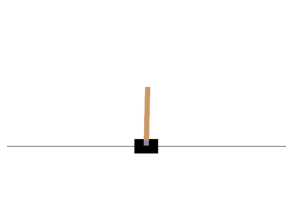

In [12]:
plot_environment(env)
plt.show()

```action = 1```을 취했을 때, 환경이 조금 변화하는 것을 관찰할 수 있다. 

액션을 수행할 때는 ```env.step``` method를 이용한다.  

액션을 수행하면, 액션 수행에 따른 환경에 대한 다음을 얻을 수 있다.
* 관찰값(```obs```),  
* 보상(```reward```, 이 예제에서는 항상 1을 제공),  
* ```done```(```True```일 경우 막대가 너무 기울거나 화면 밖으로 나가거나 200회가 지나 게임 종료),  
* ```info```  


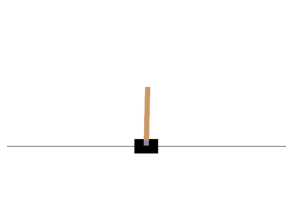

In [13]:
action = 1
obs, reward, done, info, *others = env.step(action)
plot_environment(env)
plt.show()

막대가 왼쪽으로 기울었으면 카트를 왼쪽으로 가속하고, 막대가 오른쪽으로 기울었으면 카트도 오른쪽으로 가속하는 단순 정책을 정의해 보자.

In [14]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

이 정책으로 게임 에피소드를 500번 진행하겠다. 

각 에피소드마다 총 얼마의 보상을 받았는지 기록한다.

In [15]:
totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info, *others = env.step(action)
        episode_rewards += reward
        if done:
            break
    
    totals.append(episode_rewards)

Total reward에 대한 통계량을 살펴보자.  

평균적으로 42회 가량 막대를 유지했고, 많게는 대략 70번까지 유지했다.

In [16]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.424, 8.747812526569142, 24.0, 67.0)

실제 움직이는 모습을 보기 위해, animation을 이용하였다.

아래 코드는 각 step 마다 image를 받아와 ```frames```에 담아 animation으로 만드는 과정이다.

In [17]:
frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info, *others = env.step(action)
    if done:
        break

In [18]:
len(frames)

45

In [19]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [20]:
plot_animation(frames)

## 신경망 정책

신경망 정책에서는 관측을 입력으로 받아 해야할 액션에 대한 확률값을 추정한다.  

이 확률값에 따라 어느 쪽으로 가속할지 랜덤하게 결정한다.

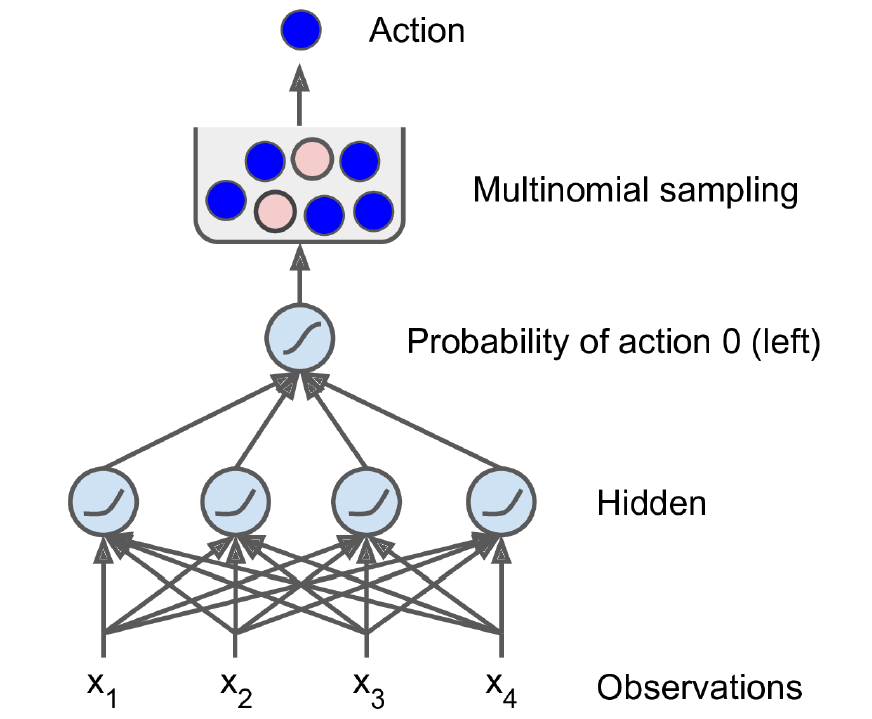

확률을 기반으로 한 랜덤 선택은 새로운 행동에 대한 탐험(exploring)과 활용(exploiting)을 모두 할 수 있도록 한다.  

높은 확률로 더 괜찮다고 판단한 행동을 활용(exploit)하지만, 적은 확률로 의외의 행동을 탐험(explore)할 수도 있다.

여기서는 뉴런 5개의 은닉층 하나를 가지는 간단한 신경망을 만들어 본다.

입력은 ```obs```의 4가지 관찰값이다.

출력은 확률값으로, 이 예제에서는 왼쪽(행동 0)으로 가속할 확률이다.

In [21]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_inputs = 4 # == env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [22]:
obs.reshape(1,-1)

array([[-0.27008486, -1.0062717 ,  0.22963296,  1.2057713 ]],
      dtype=float32)

다음은 주어진 신경망 모형으로 게임을 수행하는 간단한 예제이다.  

아직 훈련을 하지 않은 신경망이다.

In [23]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.reset(seed=seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        # 다음 action을 베르누이 시행처럼 랜덤하게 결정한다. 
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info, *others = env.step(action)
        if done:
            break
    env.close()
    return frames

In [24]:
len(frames)

45

In [25]:
frames = render_policy_net(model)
plot_animation(frames)

1/1 [==============================] - ETA: 0s

c:\Users\Owner\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\Owner\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\Owner\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


1/1 [==============================] - 0s 10ms/step


## 정책 그레디언트 (Policy gradient)

정책 그레디언트 알고리즘은 높은 보상을 얻는 방향으로 모형의 파라미터들을 최적화하는 방법이다.

인기 있는 정책 그레디언트 알고리즘 중의 하나는 reinforce 알고리즘이다.  

* 각 스텝에서 액션이 랜덤하게 선택되는데, 이 액션이 더 높은 확률을 가지도록 하는 그레디언트를 계산한다. 

* 에피소드를 몇 번 실행한 후, 각 행동들의 이익을 계산한다. 

* 각 행동의 이익이 양수이면 좋은 행동이므로 앞서 계산한 그레디언트를 적용하여 파라미터를 업데이트하도록 한다. 이익이 음수이면 나쁜 행동이므로, 반대의 그레디언트를 적용한다.

* 마지막으로 모든 그레디언트 벡터를 평균내어 경사 하강법을 수행한다. 

아래 코드에서 ```tf.GradientTape()```는 자동으로 모든 파라미터에 대한 gradient를 계산할 수 있도록 한다.

In [26]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        # 1 - action
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info, *others = env.step(int(action[0, 0].numpy()))
    
    return obs, reward, done, grads

```play_multiple_episodes```에서는 에피소드를 여러 번 진행한다.

각 에피소드 당 스텝 별로 보상과 gradient를 계산해 기록해 놓는다.

In [27]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

적당한 할인율을 이용하여 미래 보상을 discount 한다.

In [28]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

여러 에피소드에 걸쳐 계산된 보상에서 평균을 빼고 표준편차를 나누어 정규화 한다.

In [29]:
def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std for discounted_rewards in all_discounted_rewards]

예를 들어, 각 스텝에서의 보상이 10, 0, -50이고, 할인율이 0.8이면, 할인된 미래 보상은 다음과 같다.

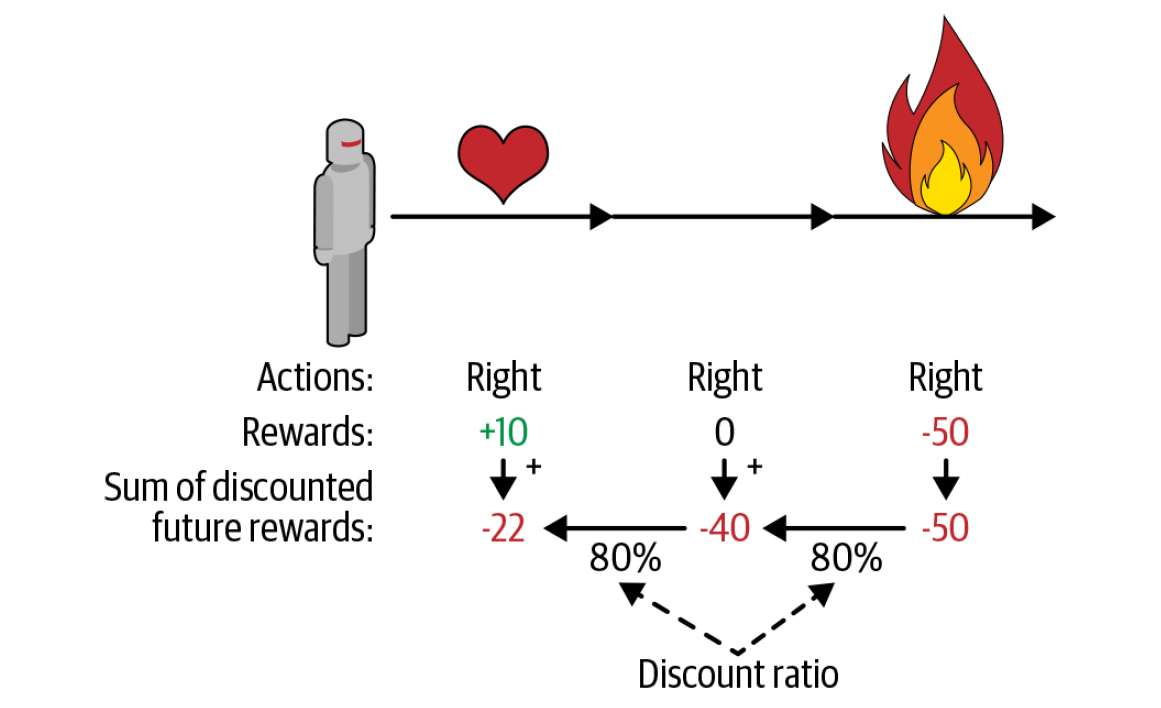

In [30]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22, -40, -50])

In [31]:
result = discount_rewards([10, 0, -50], discount_rate=0.8)
(result - result.mean()) / result.std()

array([ 1.32350128, -0.23017414, -1.09332714])

In [32]:
discount_and_normalize_rewards([[10, 0, -50]], discount_rate=0.8)

[array([ 1.32350128, -0.23017414, -1.09332714])]

여러 이익 시나리오가 있을 때는 전체 discount_reward에 대한 평균과 표준편차로 표준화한다.

아래에서 ```[10, 0, -50]```보다 ```[10, 20]```가 좋은 행동으로 볼 수 있다.

In [33]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

반복과 관련된 횟수를 정하자.

In [34]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

손실 함수는 이진 크로스 엔트로피 함수이다.

In [35]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

In [36]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

```model.trainable_variables```은 다음으로 요약된다.

* 첫번째 Dense 층의 $4 \times 5$의 $W$ 파라미터,  
* 첫번째 Dense 층의 5개의 bias 파라미터,  
* 두번째 Dense 층의 $5 \times 1$의 $W$ 파라미터,  
* 두번째 Dense 층의 1개의 bias 파라미터,  

In [37]:
model.trainable_variables

[<tf.Variable 'dense/kernel:0' shape=(4, 5) dtype=float32, numpy=
 array([[ 0.26872885, -0.09633553, -0.24024189, -0.05799979, -0.7615294 ],
        [ 0.30156875,  0.3921101 ,  0.60819936, -0.44690722, -0.45201764],
        [-0.30963498,  0.36307287, -0.59900284,  0.07848799,  0.12183565],
        [ 0.6526804 , -0.8010425 ,  0.03466958,  0.21971023, -0.49099484]],
       dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(5,) dtype=float32, numpy=array([0., 0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'dense_1/kernel:0' shape=(5, 1) dtype=float32, numpy=
 array([[ 0.3757825 ],
        [-0.03104234],
        [ 0.8619888 ],
        [-0.49562597],
        [ 0.46230793]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

시험 삼아 ```play_one_step```함수를 적용해 보자.

In [38]:
env = gym.make("CartPole-v1")
obs = env.reset()

obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)

c:\Users\Owner\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\Owner\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


한 스텝 후 새로운 observation

In [39]:
obs

array([-0.00653991,  0.23223986,  0.04828046, -0.29607263], dtype=float32)

In [40]:
reward

1.0

In [41]:
grads

[<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
 array([[-0.00134471,  0.00011311, -0.00312512,  0.00177574, -0.00168456],
        [ 0.00697492, -0.0005867 ,  0.01620976, -0.00921063,  0.00873766],
        [ 0.00896792, -0.00075435,  0.02084153, -0.01184246,  0.01123436],
        [-0.00352573,  0.00029657, -0.00819382,  0.00465585, -0.00441678]],
       dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([ 0.18428592, -0.01550142,  0.428282  , -0.24335614,  0.23085989],
       dtype=float32)>,
 <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[-0.00895808],
        [ 0.02423779],
        [-0.0025106 ],
        [-0.00835627],
        [ 0.0018832 ]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.4993639], dtype=float32)>]

In [42]:
grads[0]

<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
array([[-0.00134471,  0.00011311, -0.00312512,  0.00177574, -0.00168456],
       [ 0.00697492, -0.0005867 ,  0.01620976, -0.00921063,  0.00873766],
       [ 0.00896792, -0.00075435,  0.02084153, -0.01184246,  0.01123436],
       [-0.00352573,  0.00029657, -0.00819382,  0.00465585, -0.00441678]],
      dtype=float32)>

In [43]:
grads[1]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 0.18428592, -0.01550142,  0.428282  , -0.24335614,  0.23085989],
      dtype=float32)>

In [44]:
grads[2]

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.00895808],
       [ 0.02423779],
       [-0.0025106 ],
       [-0.00835627],
       [ 0.0018832 ]], dtype=float32)>

In [45]:
grads[3]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.4993639], dtype=float32)>

시험삼아 ``` play_multiple_episodes``` 함수를 적용해 보자.

In [46]:
all_rewards, all_grads = play_multiple_episodes(env, n_episodes = 2, n_max_steps = 10, model = model, loss_fn = loss_fn)

```n_episodes = 2```, ```n_max_steps = 10```로 설정했기 때문에 두 개의 에피소드에 대해 각 10개의 reward가 있다.  
각 reward는 현재로서는 (아마도) 모두 1.0

In [47]:
all_rewards

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]

(파이썬 인덱스 기준) 1번째 episode의 5번째 step에서 0번째 파라미터 집합에 대한 gradient

In [48]:
all_grads[1][5][0]

<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
array([[ 1.24182859e-02, -1.12809648e-03,  3.13251689e-02,
        -1.55051183e-02,  1.65875666e-02],
       [ 3.55842970e-02, -3.23253311e-03,  8.97615105e-02,
        -4.44295406e-02,  4.75312732e-02],
       [ 1.28049869e-03, -1.16322495e-04,  3.23006231e-03,
        -1.59879413e-03,  1.71040976e-03],
       [-4.70446981e-02,  4.27361391e-03, -1.18670419e-01,
         5.87386712e-02, -6.28393590e-02]], dtype=float32)>

```discount_and_normalize_rewards```를 사용하여 보상들을 정규화할 수 있다.  
현재로서는 reward가 모두 1이었기 때문에, ```discount_rate```에 의한 효과만 반영되어 있다.

In [49]:
discount_and_normalize_rewards(all_rewards, discount_rate=0.8)

[array([ 1.13673434,  1.0145201 ,  0.8617523 ,  0.67079255,  0.43209287,
         0.13371826, -0.23925   , -0.70546033, -1.28822323, -2.01667686]),
 array([ 1.13673434,  1.0145201 ,  0.8617523 ,  0.67079255,  0.43209287,
         0.13371826, -0.23925   , -0.70546033, -1.28822323, -2.01667686])]

```n_max_steps```을 조금 더 늘려서 테스트

In [50]:
all_rewards, all_grads = play_multiple_episodes(env, n_episodes = 2, n_max_steps = 50, model = model, loss_fn = loss_fn)
len(all_rewards[0]), len(all_rewards[1])

(27, 15)

In [51]:
all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=0.8)
all_final_rewards

[array([ 0.82771236,  0.82500026,  0.82161013,  0.81737246,  0.81207538,
         0.80545403,  0.79717735,  0.78683149,  0.77389916,  0.75773376,
         0.73752701,  0.71226856,  0.68069551,  0.64122919,  0.59189629,
         0.53023017,  0.45314751,  0.3567942 ,  0.23635255,  0.08580049,
        -0.10238958, -0.33762717, -0.63167415, -0.99923289, -1.4586813 ,
        -2.03299182, -2.75087998]),
 array([ 0.68069551,  0.64122919,  0.59189629,  0.53023017,  0.45314751,
         0.3567942 ,  0.23635255,  0.08580049, -0.10238958, -0.33762717,
        -0.63167415, -0.99923289, -1.4586813 , -2.03299182, -2.75087998])]

가중처리된 gradient 계산하기: 해당 ```episode_index```와 ```step_index```의 정규화된 보상값을 가중치로하여 계산한다.

아래 가중치가 음수이면 해당 스텝의 행동은 안 좋게 평가되는 것이고, 양수이면 좋게 평가되는 것이다.

In [52]:
var_index = 0
episode_index = 1
step = 5

# 해당 인덱스의 가중치
all_final_rewards[episode_index][step] 

0.356794197710437

In [53]:
all_final_rewards[episode_index][step] * all_grads[episode_index][step][var_index]

<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
array([[ 0.00220014, -0.00012995,  0.00450826, -0.0029018 ,  0.00251428],
       [ 0.0119352 , -0.00070497,  0.02445623, -0.01574154,  0.01363936],
       [-0.00374835,  0.0002214 , -0.00768068,  0.00494376, -0.00428356],
       [-0.02607524,  0.00154017, -0.05343037,  0.03439108, -0.02979839]],
      dtype=float32)>

모든 에피소드와 스텝에 대해 gradient를 계산한다.  
아래에서는 ```var_index = 0```인 것에 대한 예제

In [54]:
weighted_grads_list = []
for episode_index, final_rewards in enumerate(all_final_rewards):
    for step, final_reward in enumerate(final_rewards):
        #weighted_grads = final_reward * all_grads[episode_index][step][var_index]
        weighted_grads = all_final_rewards[episode_index][step] * all_grads[episode_index][step][var_index]
        weighted_grads_list.append(weighted_grads)
weighted_grads_list

[<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
 array([[-0.00270193,  0.0002335 , -0.00628259,  0.00372814, -0.00347752],
        [-0.00529847,  0.0004579 , -0.01232011,  0.00731086, -0.00681939],
        [ 0.00313463, -0.0002709 ,  0.00728872, -0.00432519,  0.00403443],
        [-0.00509553,  0.00044036, -0.01184825,  0.00703085, -0.00655821]],
       dtype=float32)>,
 <tf.Tensor: shape=(4, 5), dtype=float32, numpy=
 array([[ 0.0023605 , -0.00023181,  0.00643689, -0.00322199,  0.00345228],
        [-0.01956821,  0.00192166, -0.05336097,  0.02670988, -0.02861893],
        [-0.00254949,  0.00025037, -0.00695227,  0.00347997, -0.00372869],
        [ 0.03953436, -0.0038824 ,  0.1078071 , -0.05396293,  0.05781987]],
       dtype=float32)>,
 <tf.Tensor: shape=(4, 5), dtype=float32, numpy=
 array([[-0.00235432,  0.00020117, -0.00543302,  0.00321189, -0.00299598],
        [-0.00541416,  0.00046262, -0.01249413,  0.00738628, -0.00688974],
        [ 0.00210286, -0.00017968,  0.00485271, -0.00

그레디언트의 가중평균을 구한다. ```var_index = 0```인 파라미터의 개수와 같은 $4\times5$이다.

In [55]:
tf.reduce_mean(weighted_grads_list, axis=0)

<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
array([[ 1.44850230e-03, -4.30762666e-05,  2.47233547e-03,
        -1.84160075e-03,  1.52939011e-03],
       [ 8.09412729e-03, -3.81259393e-04,  1.62552036e-02,
        -1.09851165e-02,  9.61006992e-03],
       [-2.79883295e-03,  9.44801141e-05, -5.05729858e-03,
         3.50372284e-03, -3.11174383e-03],
       [-1.86497346e-02,  8.48385738e-04, -3.68364975e-02,
         2.46062055e-02, -2.18870863e-02]], dtype=float32)>

In [56]:
env.close()

본격적으로 반복을 통해 신경망을 훈련한다.

환경을 초기화하고, 반복문 내에서 ```play_multiple_episodes```를 통해 ```n_episodes_per_update=10```번씩 플레이하고, 각 에피소드에서 계산된 스텝 당 reward값과 gradient를 기록해 두겠다.  
* 이 값들은 ```all_rewards```와 ```all_grads```라는 리스트에 저장된다. 

그 다음 ```discount_and_normalize_rewards```와 적당한 ```discount_rate```을 통해, 정규화된 이익으로 변환한다.  
* 정규화된 이익(```all_final_rewards```)은 각 action들이 실제로 좋은 행동이었는지 아니었는지를 판단하는 기준이 된다.

그 다음 가중 평균된 그레디언트를 통해 모형의 parameter들을 업데이트할 차례이다.
* 가중 평균 gradient는 각 에피소드별 스텝별 정규화된 reward를 가중치로 하여 

In [57]:
env = gym.make("CartPole-v1")
env.seed(42);

for iteration in range(n_iterations):
    
    # n_episodes_per_update=10번 플레이하고, 각 에피소드에서 계산된 스텝 별 보상과 그레디언트를 반환
    all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, n_max_steps, model, loss_fn)
    
    # 화면 print를 위한 부분
    total_rewards = sum(map(sum, all_rewards))                     
    print("\rIteration: {}, mean rewards: {:.1f}".format(iteration, total_rewards / n_episodes_per_update), end="") 
    
    # 정규화된 이익을 계산, 각 행동이 실제로 얼마나 좋은지 나쁜지 판단
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
    
    # 모든 훈련 가능 변수에 대해 final_reward로 가중 평균한 그레디언트를 적용
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):  
        weighted_grads_list = []
        
        for episode_index, final_rewards in enumerate(all_final_rewards):
            for step, final_reward in enumerate(final_rewards):
                weighted_grads = all_final_rewards[episode_index][step] * all_grads[episode_index][step][var_index]
                weighted_grads_list.append(weighted_grads)
                
        mean_grads = tf.reduce_mean(weighted_grads_list, axis=0)
        
        all_mean_grads.append(mean_grads)
    
    # 평균 그레디언트를 옵티마이저에 적용하여 모형 파라미터 업데이트
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

c:\Users\Owner\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Iteration: 149, mean rewards: 200.0

애니메이션을 통하여 훈련된 내용을 확인해 보자.

In [58]:
frames = render_policy_net(model)
plot_animation(frames)

1/1 [==============================] - ETA: 0s

c:\Users\Owner\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


1/1 [==============================] - 0s 10ms/step


In [59]:
len(frames)

200